<a href="https://colab.research.google.com/github/jerrysze/Retinal-Vessel-Segmentation/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi
#Check allocated GPU

Mon Jun 19 07:51:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import the libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
import matplotlib.pyplot as plt

## Download the dataset


In [ ]:
!wget --user=cyszeae --ask-password https://course.cse.ust.hk/comp2211/assignments/pa2/data/retinal_vessel_dataset.npz
!wget --user=cyszeae --ask-password https://course.cse.ust.hk/comp2211/assignments/pa2/data/sample_data.npz
# Make sure to download both!

Password for user ‘cyszeae’: 
--2023-06-19 07:53:55--  https://course.cse.ust.hk/comp2211/assignments/pa2/data/retinal_vessel_dataset.npz
Resolving course.cse.ust.hk (course.cse.ust.hk)... 143.89.41.176
Connecting to course.cse.ust.hk (course.cse.ust.hk)|143.89.41.176|:443... connected.
HTTP request sent, awaiting response... 401 Unauthorized
Authentication selected: Basic realm="Enter Your CSD PC/Unix Password"
Reusing existing connection to course.cse.ust.hk:443.
HTTP request sent, awaiting response... 200 OK
Length: 37749978 (36M)
Saving to: ‘retinal_vessel_dataset.npz’

retinal_vessel_data 100%[===================>]  36.00M  10.4MB/s    in 3.5s    

2023-06-19 07:54:00 (10.4 MB/s) - ‘retinal_vessel_dataset.npz’ saved [37749978/37749978]

Password for user ‘cyszeae’: 
--2023-06-19 07:54:06--  https://course.cse.ust.hk/comp2211/assignments/pa2/data/sample_data.npz
Resolving course.cse.ust.hk (course.cse.ust.hk)... 143.89.41.176
Connecting to course.cse.ust.hk (course.cse.ust.hk)|143.

## Data loading

Processing the entire retinal image will require complex models and techniques. I will use **cropped patches** of the grayscaled retinal image. In total, I will provide 537 pairs of images and corresponding vessel masks for training and 173 pairs for validation.


In [ ]:
retinal_vessel_data = np.load('retinal_vessel_dataset.npz')
implementation_check = np.load('sample_data.npz')
x_train_raw = retinal_vessel_data["x_train"][...,np.newaxis]
y_train = retinal_vessel_data["y_train"][...,np.newaxis].astype(int)
x_val_raw = retinal_vessel_data["x_val"][...,np.newaxis]
y_val = retinal_vessel_data["y_val"][...,np.newaxis].astype(int)
print("x_train_raw.shape", x_train_raw.shape)   #Each patch has a shape 64 X 64.
print("y_train.shape", y_train.shape)
print("x_val_raw.shape", x_val_raw.shape)
print("y_val.shape", y_val.shape)


x_train_raw.shape (537, 64, 64, 1)
y_train.shape (537, 64, 64, 1)
x_val_raw.shape (173, 64, 64, 1)
y_val.shape (173, 64, 64, 1)


## Lets visualize some examples

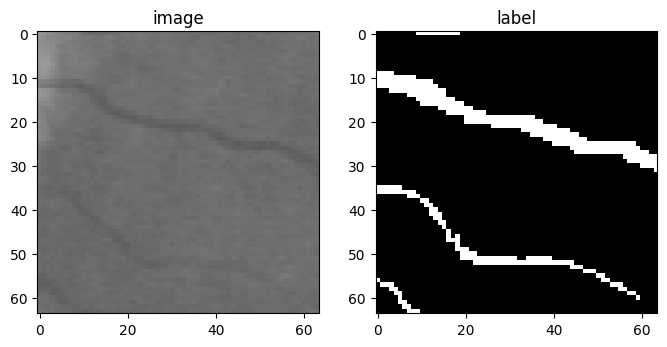

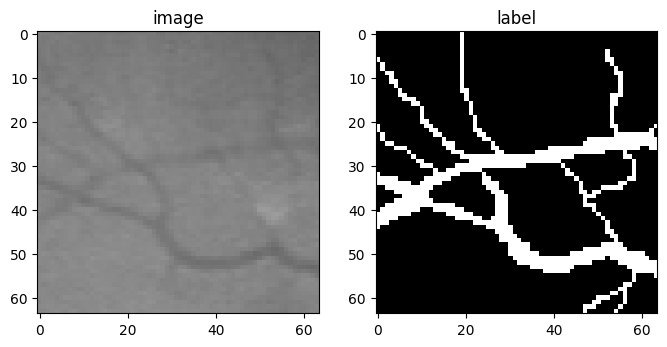

In [ ]:
# Helper functions for visualization
def visualize_side_by_side(img1, img1caption,
                            img2, img2caption,
                            img2range = (0,255), img1range = (0,255)):

    fig, axs = plt.subplots(1,2, figsize=(8,16))
    axs[0].imshow(img1,cmap='gray',vmax=img1range[1],vmin=img1range[0])
    axs[1].imshow(img2,cmap='gray',vmax=img2range[1],vmin=img2range[0])
    axs[0].set_title(img1caption)
    axs[1].set_title(img2caption)
    fig.show()

def visualize_side_by_3(img1, img1caption,
                         img2, img2caption,
                         img3, img3caption,
                         img1range = (0,255), img2range = (0,255), img3range = (0,255)):

    fig, axs = plt.subplots(1,3, figsize=(16,24))
    axs[0].imshow(img1,cmap='gray',vmax=img1range[1],vmin=img1range[0])
    axs[1].imshow(img2,cmap='gray',vmax=img2range[1],vmin=img2range[0])
    axs[2].imshow(img3,cmap='gray',vmax=img3range[1],vmin=img3range[0])
    axs[0].set_title(img1caption)
    axs[1].set_title(img2caption)
    axs[2].set_title(img3caption)
    fig.show()


visualize_side_by_side(x_train_raw[21,...], 'image', y_train[21,...], 'label', img2range = (0,1))
visualize_side_by_side(x_train_raw[121,...], 'image', y_train[121,...], 'label', img2range = (0,1))

## Task 1: Contrast Stretching

As you can see from the above example, retinal images are low-contrast images. In other words, the intensities of the vessels do not stand out by a large margin compared to the background. As such, I will enhance the retinal images by stretching their contrast.

I will use the following contrast stretching formulas:

$\mathcal{I}_{new}=\frac{\mathcal{I}-\mathcal{I}_{min}}{\mathcal{I}_{max}-\mathcal{I}_{min}}\times255$,
where

* $\mathcal{I}$ is the current pixel intensity value
* $\mathcal{I}_{min}$ is the minimum intensity value present in the whole image
* $\mathcal{I}_{max}$ is the maximum intensity value present in the whole image
* $\mathcal{I}_{new}$ is the new output intensity value.




<code>contrast_stretch()</code> function expects the **entire** image array <code>x_train_raw</code> and <code>x_val_raw</code> and returns a new image array, in which each image in the array is **individually** stretched.
<br>




In [ ]:
def contrast_stretch(x):
  """ Stretch the contrast of each individual images in the given data array.

  Parameters
  ------------
  x : np.ndarray
      Image data array
  Returns:
  -------------
  np.ndarray
      New image data arary with individually contrast-stretched images.
  """


  ## <Loop-based solution>
  x_enhanced = np.zeros_like(x)
  for i in range(x.shape[0]):
    mini = np.min(x[i,...])
    maxi = np.max(x[i,...])
    x_enhanced[i,...] = (((x[i,...]-mini) / (maxi-mini))*255)

  # <Vectorized solution>
  # max_each = x.max(axis=(1,2,3)).reshape(-1,1,1,1)
  # min_each = x.min(axis=(1,2,3)).reshape(-1,1,1,1)
  # x_enhanced = (x-min_each) / (max_each-min_each) * 255

  return x_enhanced


x_train_enhanced = contrast_stretch(x_train_raw)
x_val_enhanced = contrast_stretch(x_val_raw)

Check implementation of Task 1 with the code cell below. The last print statement will output <code>True</code> if your enhanced image is similar enough to the expected enhanced image.


True


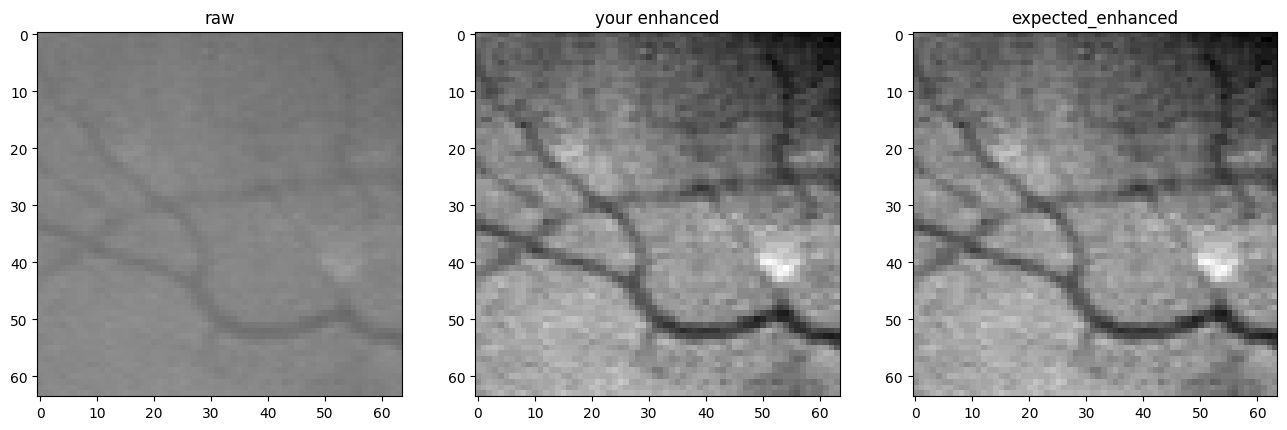

In [ ]:
sample_enhanced = implementation_check['sample_enhanced']
your_enhanced = contrast_stretch(x_train_raw)[121] # This code uses 121st training image for comparison. We will compare every training image for grading.

visualize_side_by_3(x_train_raw[121,...], 'raw', x_train_enhanced[121,...],'your enhanced', sample_enhanced,'expected_enhanced')
print((np.abs(sample_enhanced - your_enhanced.squeeze()) > 1).sum() == 0) # Checks whether your enhanced image is similar enough to the expected enhanced image.

## Task 2: Image Re-scaling

Our contrast-enhanced data arrays <code>x_train_enhanced</code> and <code>x_val_enhanced</code> are arrays in the range of $[0,255]$. Need to standardize the input by rescaling the pixel values to $[0,1]$.


In [ ]:
def rescale_01(x):
  """ Rescales the given image data array to range [0,1].

  Parameters
  ------------
  x : np.ndarray
      image data array

  Returns:
  -------------
  np.ndarray
      New image data arary re-scaled to range [0,1].
  """

  x_01 = x/255

  return x_01.astype(float)


x_train = rescale_01(x_train_enhanced)
x_val = rescale_01(x_val_enhanced)


# CNN Model

I will build a special type of CNN model called the **Autoencoder** to perform automatic segmentation of retinal vessels.


<br>

### Recap: Image Classification with CNN

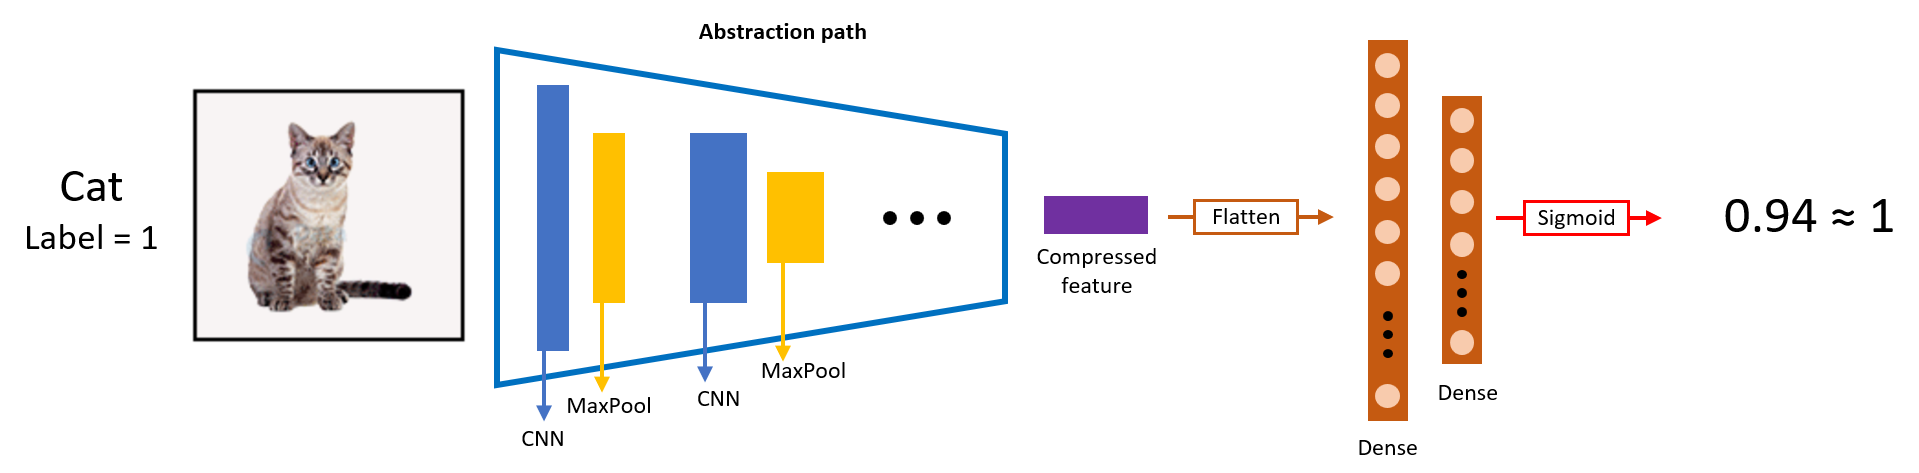

First, recall the architecture of the CNN image classification model introduced in class. Image undergoes an "abstraction" path that reduces the spatial dimension of the input via pooling operations while increasing the number of channels with convolution layers along the path. The compressed feature resulting from the abstraction path subsequently gets flattened, from which a set of dense layers further manipulates the flattened features to yield the final classification prediction.

### Autoencoder

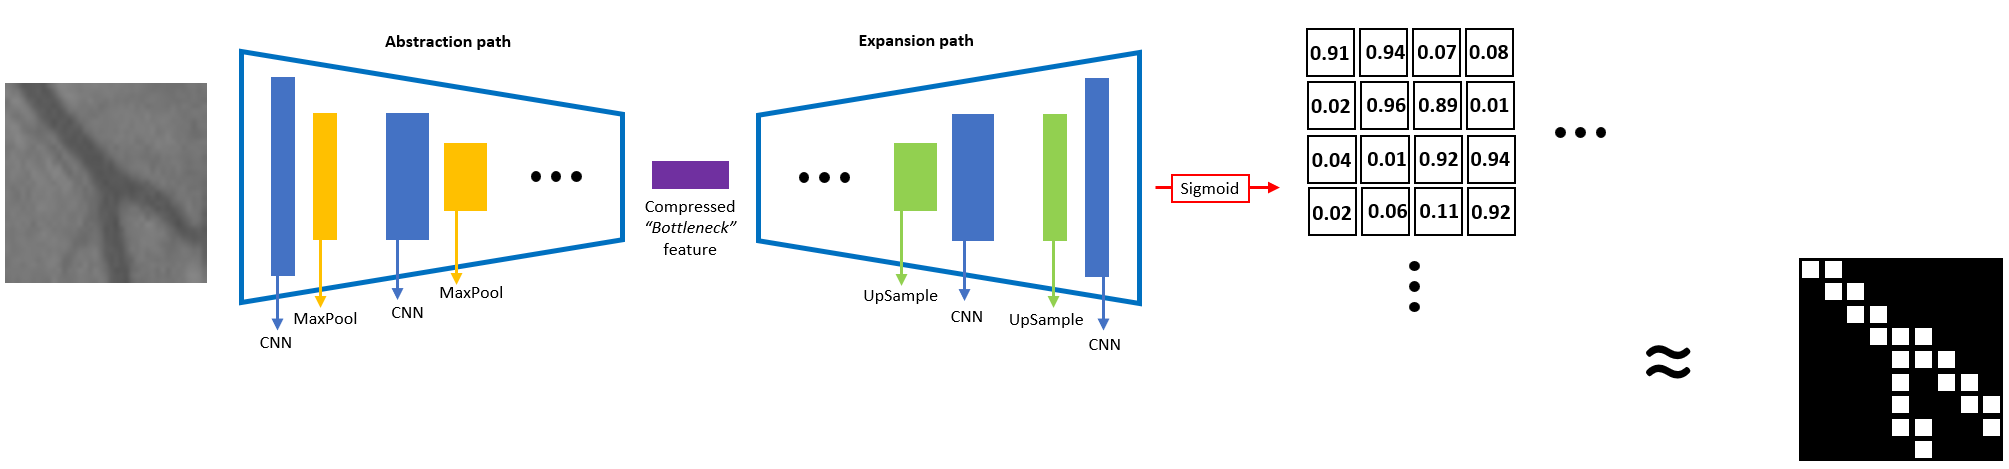

Autoencoder, or an "hourglass" model, is a simple extension of the previously mentioned image classification model. The process of obtaining the compressed feature shares the same concept of **abstraction path** introduced in the classification model. The compressed feature is then propagated to the **expansion** path, which **de-compresses** the compressed feature back to the spatial representation of the image. In this arrangement, the compressed feature is often called the "Bottleneck" feature.

<br>

I will use this autoencoder architecture to build a model that can learn to produce a segmentation mask from the input image. Intuitively, I expect the output of the autoencoder to be the predicted segmentation mask. During training, the loss will be computed between the real label mask and the predicted mask.

### UpSampling operation

To build the autoencoder, we first need to learn how to use the "Upsampling" operation in our model. Simply put, the upsampling operation is the direct opposite of the pooling layers introduced in class. Instead of reducing the size of the input, it **increases** the dimension with respect to the given size. While there are multiple algorithms for filling up the values of the increased spatial dimension, we will use the default "nearest neighbor" approach, which simply copies the nearest value from the value of interest.

<code>tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="nearest")</code>

For example, an upsampling layer below with size (2, 2) will increase the spatial size by 2 on the horizontal dimension and 2 on the vertical dimension.

<br>

Before moving on to the next task, please read the following Keras [documentation](https://keras.io/api/layers/reshaping_layers/up_sampling2d/) on upsampling layer.









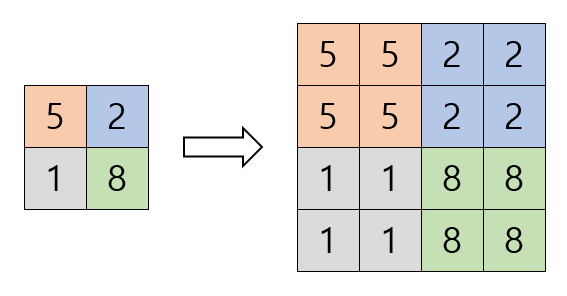

## Task 3: Build the autoencoder model.
In this task, I will implement the autoencoder model using a Keras <code>Sequential</code>. Here is a **sample** architecture of the autoencoder. All the layers below can sequentially be added to the <code>Sequential</code> model instance to create the autoencoder.
Refer to [keras Sequential](https://keras.io/api/models/sequential/) documentation.
<br>

=====================================<br>
Abstraction path:
* A [convolutional layer](https://keras.io/api/layers/convolution_layers/convolution2d/) with 4 3*3 kernels
* A [dropout layer](https://keras.io/api/layers/regularization_layers/dropout/) with drop rate = 0.1
* A convolutional layer with 4 3*3 kernels
* A 2*2 max pooling layer

* A convolutional layer with 8 3*3 kernels
* A dropout layer with drop rate = 0.1
* A convolutional layer with 8 3*3 kernels
* A 2*2 max pooling layer



Bottleneck path:
* A convolutional layer with 16 3*3 kernels
* A dropout layer with drop rate = 0.2
* A convolutional layer with 16 3*3 kernels

Expansion path:
* A 2*2 [upsampling layer](https://keras.io/api/layers/reshaping_layers/up_sampling2d/) with "nearest neighbor" interpolation.
* A convolutional layer with 8 3*3 kernels
* A dropout layer with drop rate = 0.1
* A convolutional layer with 8 3*3 kernels

* A 2*2 upsampling layer with "nearest neighbor" interpolation.
* A convolutional layer with 4 3*3 kernels
* A dropout layer with drop rate = 0.1
* A convolutional layer with 4 3*3 kernels

Final Layer - **FIXED, implement as described!**:
* A convolutional layer with 1 1*1 kernels

<br>
<br>

All convolutional layers EXCEPT the final convolutional layer are initialized with ReLU activation, ["He normal"](https://keras.io/api/layers/initializers/#henormal-class) kernel initializer, and <code>"same"</code> padding.
<br>

The final convolution layer is initialized with Sigmoid activation and He normal kernel initializer.<br>
=====================================<br>
<br>

Side note: A model that is too complex can harm performance. Try to keep your model under 500,000 trainable parameters.

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout

def build_model():
    """Creates and returns a model described above

    Returns
    -------
    keras.Model
        The Sequential model created
    """

    # model 1 (Validation Avgerage Dice ~ 0.68)

    # model = Sequential([

    #     #Encoder
    #     Conv2D(4, (3,3), activation="relu", kernel_initializer="he_normal",padding='same'),
    #     Dropout(0.1),
    #     Conv2D(4, (3,3), activation="relu", kernel_initializer="he_normal",padding='same'),
    #     MaxPooling2D((2,2)),

    #     Conv2D(8, (3,3), activation="relu", kernel_initializer="he_normal",padding='same'),
    #     Dropout(0.1),
    #     Conv2D(8, (3,3), activation="relu", kernel_initializer="he_normal",padding='same'),
    #     MaxPooling2D((2,2)),

    #     #Bottleneck
    #     Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal",padding='same'),
    #     Dropout(0.2),
    #     Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal",padding='same'),

    #     #Decoder
    #     UpSampling2D((2,2), interpolation="nearest"),
    #     Conv2D(8, (3,3), activation="relu", kernel_initializer="he_normal",padding='same'),
    #     Dropout(0.1),
    #     Conv2D(8, (3,3), activation="relu", kernel_initializer="he_normal",padding='same'),

    #     UpSampling2D((2,2), interpolation="nearest"),
    #     Conv2D(4, (3,3), activation="relu", kernel_initializer="he_normal",padding='same'),
    #     Dropout(0.1),
    #     Conv2D(4, (3,3), activation="relu", kernel_initializer="he_normal",padding='same'),

    #     # Final Layer
    #     Conv2D(1, (1,1), activation="sigmoid", kernel_initializer="he_normal")
    # ])



    # model 2(Validation Avgerage Dice ~ 0.76)

    model = Sequential([

        #Encoder
        Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal",padding='same'),
        Dropout(0.2),
        Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal",padding='same'),
        MaxPooling2D((2,2)),

        Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal",padding='same'),
        Dropout(0.2),
        Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal",padding='same'),
        MaxPooling2D((2,2)),

        #Bottleneck
        Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal",padding='same'),
        Dropout(0.3),
        Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal",padding='same'),

        #Decoder
        UpSampling2D((2,2), interpolation="nearest"),
        Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal",padding='same'),
        Dropout(0.2),
        Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal",padding='same'),

        UpSampling2D((2,2), interpolation="nearest"),
        Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal",padding='same'),
        Dropout(0.2),
        Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal",padding='same'),

        # Final Layer
        Conv2D(1, (1,1), activation="sigmoid", kernel_initializer="he_normal")
    ])

    model.build((None, 64,64,1))

    return model


model = build_model()
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        160       
                                                                 
 dropout (Dropout)           (None, 64, 64, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 32)        0         
                                                        

### Task 4: Compile the model

In Keras' terms, compiling a model is to set the loss function and the optimizer.

Refer to the [`model.compile`](https://keras.io/api/models/model_training_apis/#compile-method) documentation.
Implement a function that **receives a model and a learning rate as parameters** and compiles the model using:
* [`binary_crossentropy`](https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class) as loss function.
* [`Adam`](https://keras.io/api/optimizers/adam/) optimizer that takes the **given learning rate** in the function parameter as an argument. Feel free to experiment with [other keras optimizers](https://keras.io/api/optimizers) as long as it can take the given learning rate <code>lr</code>.


In [ ]:
def compile_model(model, lr):
    """Compile a model according to the description above

    Parameters
    ----------
    model : keras.Model
        The model to compile
    lr : float
        The learning rate

    Returns
    -------
    """
    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(lr)
    )


### Task 5: Train the model
Refer to [`model.fit`](https://keras.io/api/models/model_training_apis/#fit-method) documentation.
Implement a function that trains a given model using
given `x_train` & `y_train` in a batch size of 16 for a given number of epochs.
Also, provide `x_val` & `y_val` as validation data, with a validation batch size of 16 as well. Again, feel free to experiment with different training batch sizes.


In [ ]:

def train_model(model, epochs, x_train, y_train, x_val, y_val):
    """Train the model according to the description above.
    NOTE: Please return your `model.fit(...)` call
    for us to grade.

    Parameters
    ----------
    model : keras.Model
        The model to train
    epochs : int
        The number of epochs to train
    x_train : np.ndarray
    y_train : np.ndarray
    x_val : np.ndarray
    y_val : np.ndarray

    Returns
    -------
    """
    model.fit(
        x=x_train,
        y=y_train,
        batch_size=16,
        epochs=epochs,
        validation_data=(x_val, y_val),
        validation_batch_size=16,
    )

If you made it here, our model is now ready to train.

Let's train the model for 50 epochs with a learning rate of 0.001. Note that these values are merely suggested values. You are advised to experiment with different numbers of epochs and learning rates for better performance.

In [ ]:
keras.utils.set_random_seed(2211) # Reset seed, you should get the same model since this code cell

learning_rate = 0.001  # Feel free to experiment with different values!
num_epochs = 50       # Feel free to experiment with different values!

model = build_model() # Build new model with newly initialized weights
compile_model(model, learning_rate)
train_model(model, num_epochs, x_train, y_train, x_val, y_val)

Epoch 1/50
34/34 [==============================] - 15s 41ms/step - loss: 0.4962 - val_loss: 0.4956
Epoch 2/50
34/34 [==============================] - 0s 12ms/step - loss: 0.4063 - val_loss: 0.4523
Epoch 3/50
34/34 [==============================] - 0s 11ms/step - loss: 0.3627 - val_loss: 0.4109
Epoch 4/50
34/34 [==============================] - 0s 11ms/step - loss: 0.3304 - val_loss: 0.3107
Epoch 5/50
34/34 [==============================] - 0s 11ms/step - loss: 0.2822 - val_loss: 0.2555
Epoch 6/50
34/34 [==============================] - 0s 12ms/step - loss: 0.2525 - val_loss: 0.2322
Epoch 7/50
34/34 [==============================] - 0s 11ms/step - loss: 0.2361 - val_loss: 0.2147
Epoch 8/50
34/34 [==============================] - 0s 12ms/step - loss: 0.2253 - val_loss: 0.2284
Epoch 9/50
34/34 [==============================] - 0s 11ms/step - loss: 0.2200 - val_loss: 0.2024
Epoch 10/50
34/34 [==============================] - 0s 11ms/step - loss: 0.2055 - val_loss: 0.1928
Epoch 11

### Task 6: Predict the segmentation masks

Refer to [<code>model.predict</code>](https://keras.io/api/models/model_training_apis/#predict-method) documentation.

Implement a function that predicts the segmented vessels of all the images in the validation image array <code>x_val</code> using a batch size of 16. This function should return the prediction results of your model.

<br>
Note that the shapes of the vessel image and the vessel mask are **same** in size <code>(64, 64, 1)</code>. Thus, the predicted result on the entire validation dataset <code>x_val</code> should have the same shape as <code>x_val</code> itself.

In [ ]:
def predict_model(model, x_val):
    """Predict the segmentation masks of the validation data.

    Parameters
    ----------
    model : keras.Model
        The model to evaluate
    x_val : np.ndarray


    Returns
    ----------
    np.ndarray
        Predicted segmentation array on validation data
    """
    ### START YOUR CODE HERE
    val_preds = model.predict(x_val, batch_size=16)
    ### END YOUR CODE HERE

    return val_preds

val_preds = predict_model(model, x_val)
# Note that "x_val" and predicted validation masks "val_preds" should have the same shape!

11/11 [==============================] - 0s 3ms/step


Now, let's visualize some of your predicted examples from the validation dataset. Do your predictions look plausible?



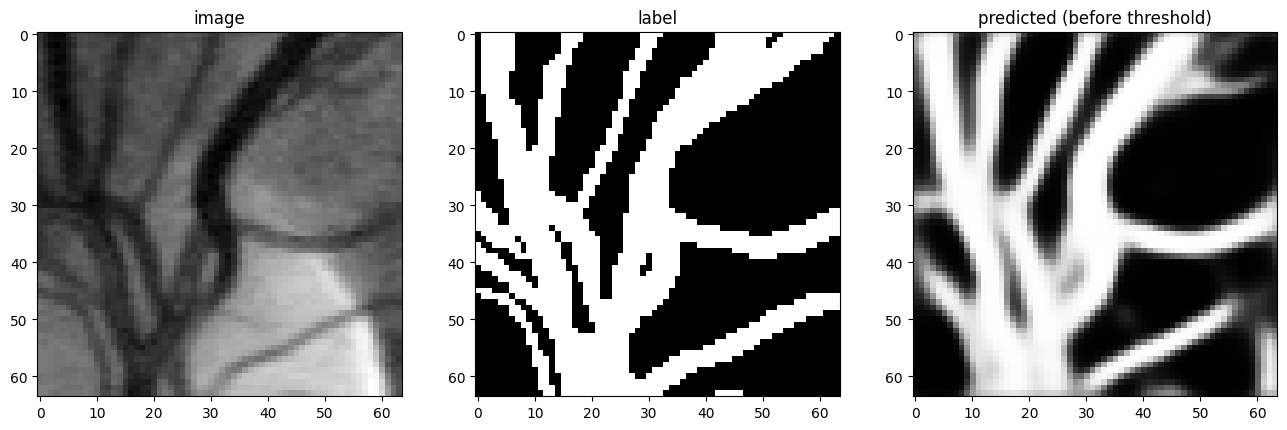

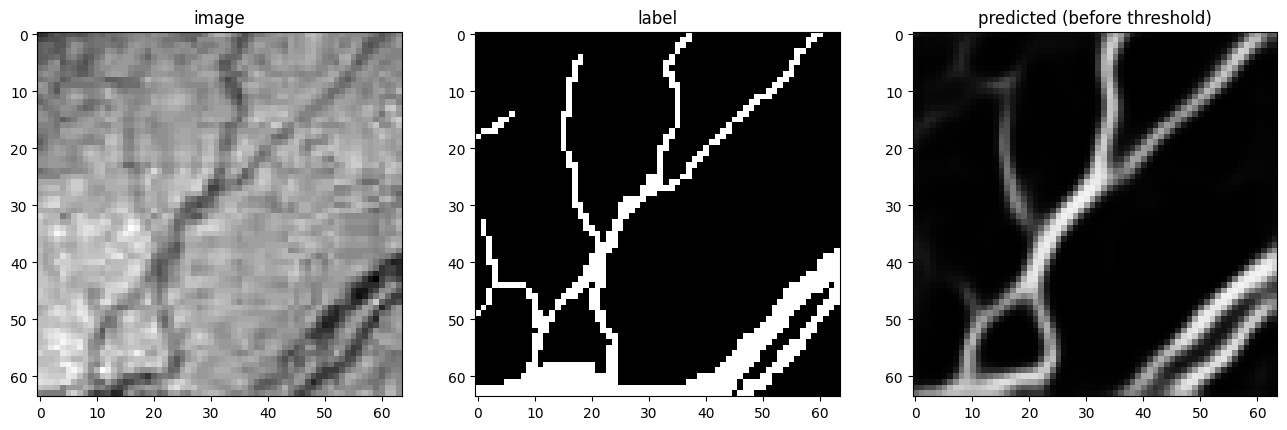

In [ ]:
visualize_side_by_3(x_val[12,...], 'image', y_val[12,...], 'label', val_preds[12,...], 'predicted (before threshold)', (0,1),(0,1),(0,1))
visualize_side_by_3(x_val[112,...], 'image', y_val[112,...], 'label', val_preds[112,...], 'predicted (before threshold)', (0,1),(0,1),(0,1))

<code>val_preds</code> contains our predicted vessel segmentation mask. However, there is one more step we need to take. Predicted masks are outputs of the sigmoid layer, which identifies the data within the range of $[0,1]$. However, as mentioned in the introduction, we expect the segmentation mask to be pixel-wise **class labels**. In other words, we want the values of our predicted mask to be either 0 or 1. To achieve this, we can consider value thresholding.

<br>

### Task 7: Mask thresholding

Implement a function that thresholds the float array within $[0,1]$ range with the value given in the function parameter. For example, for a given threshold of 0.5, values under 0.5 are reduced to zero, while remaining values equal to or larger than 0.5 are all raised to one. Additionally, all thresholded masks should be converted to the integer type.

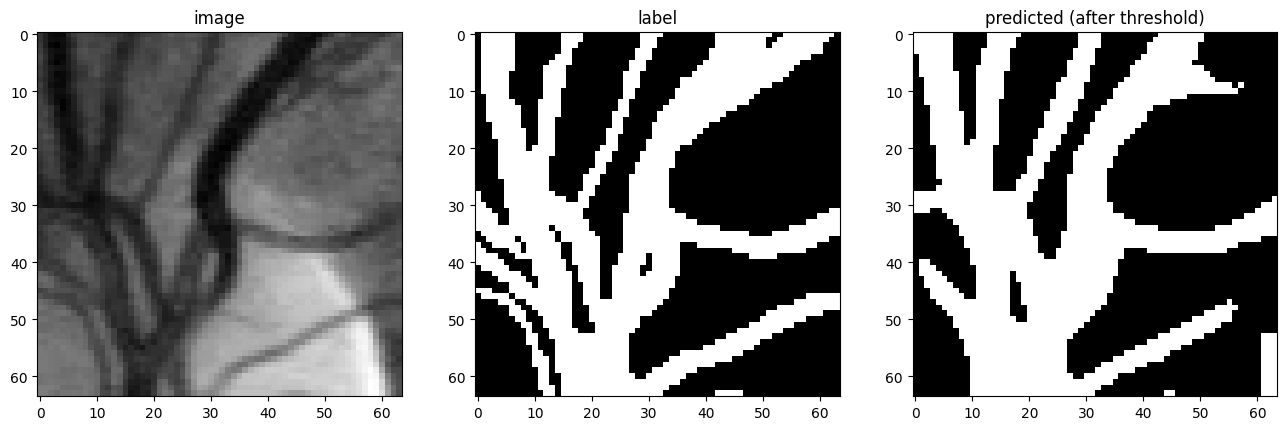

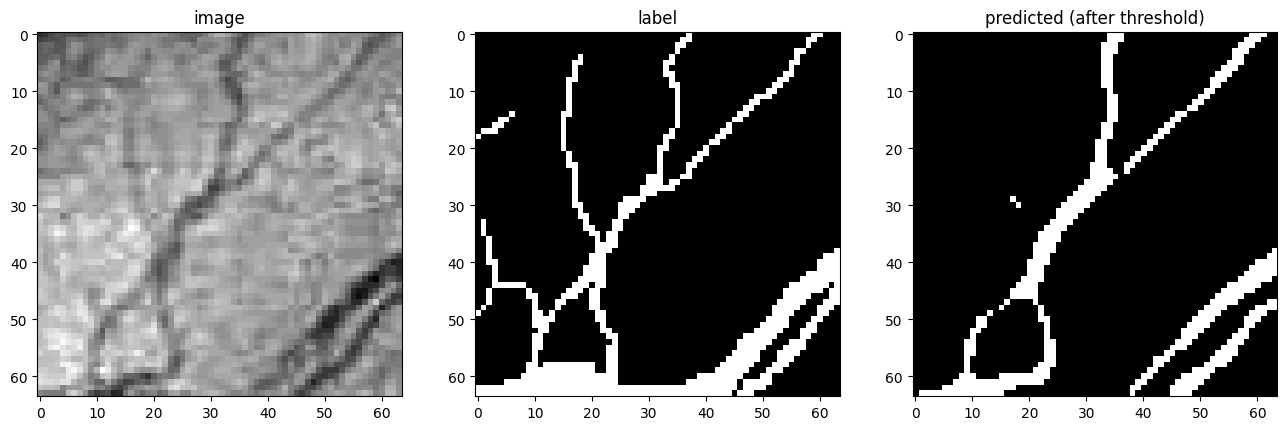

In [ ]:
def threshold(val_preds, thresh_value):
    """Threshold the given predicted mask array.

    Parameters
    ----------
    val_preds : np.ndarray
        Predicted segmentation array on validation data
    thresh_value : float

    Returns
    ----------
    np.ndarray
        Thresholded val_preds
    """

    val_preds_thresh =  (val_preds >= thresh_value)

    return val_preds_thresh.astype(int)


val_preds_thresh = threshold(val_preds, 0.5)

visualize_side_by_3(x_val[12,...], 'image', y_val[12,...], 'label', val_preds_thresh[12,...], 'predicted (after threshold)', (0,1),(0,1),(0,1))
visualize_side_by_3(x_val[112,...], 'image', y_val[112,...], 'label', val_preds_thresh[112,...], 'predicted (after threshold)', (0,1),(0,1),(0,1))

You can validate your implementation of Task 7 with the code cell below. It will compare your result with the expected sample thresholded mask and return <code>True</code> if they are identical.

True


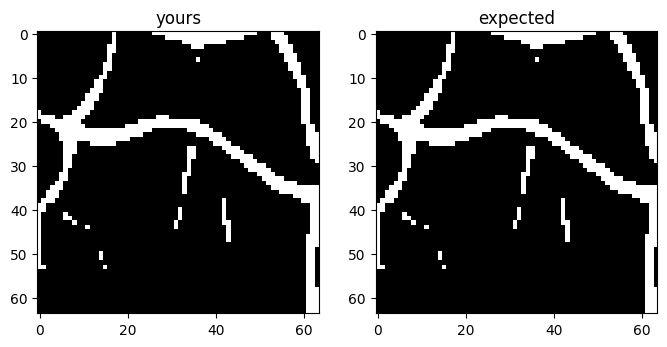

In [ ]:
sample_pred_soft = implementation_check['sample_pred_soft']
sample_pred_thresholded = implementation_check['sample_pred_hard']
your_thresholded = threshold(sample_pred_soft, 0.5)
visualize_side_by_side(your_thresholded, 'yours',sample_pred_thresholded,'expected',(0,1),(0,1))
print(np.array_equal(sample_pred_thresholded, your_thresholded)) # Checks whether your thresholded prediction is identical to the expected counterpart.

## Evaluation

metrics such as accuracy, precision, recall, F1, etc., are used to evaluate the classification result of the model. Then which metric can we use to evaluate the segmentation performance? In this part, I will introduce a new evaluation metric called the **Dice coefficient**, one the most dominantly used metrics for segmentation tasks.

### Dice coefficient

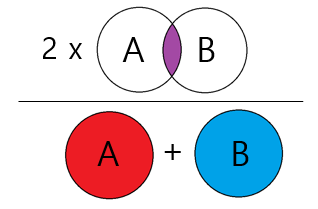

The dice coefficient measures the similarity between two segmentation masks by comparing pixel-wise agreement. It is computed as twice the area of overlap divided by the sum of the areas of both masks. The formula of the dice coefficient is given by the following:

$\frac{2\times |A\cap B|}{|A|+|B|}$

If two masks are identical, the Dice coefficient will give the highest value of 1, and if the two masks have no overlap at all, then it will give the lowest value of 0.

### Task 8: Implementing Dice coefficient
In this task, I will implement the dice coefficient based on the given description. Simply put, the dice coefficient can be computed by dividing twice the area of overlapping vessel pixels by the total vessel areas of the two masks.

<br>

Recall that binary segmentation masks consist of **either 0 or 1**. Therefore,

* Calculating the "area" of the binarized integer segmentation mask is simply counting the number of pixels represented by vessels. For this, you can conveniently use the numpy <code>sum()</code> function.
* Multiplying the two masks will only leave the intersecting area of the two masks. Calculate the area of the element-wise product of the two masks to obtain the intersecting area.

**thresholded** prediction masks will be used to compute the dice coefficient.

In [ ]:
def dice_coef(mask1, mask2):
    """Calculate the dice coeffecient score between two binary masks.

    Parameters
    ----------
    mask1 : np.ndarray
        binary mask that consists of either 0 or 1.
    mask2 : np.ndarray
        binary mask that consists of either 0 or 1.

    Returns
    ----------
    float
    """

    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice_coef_score = (2 * intersect ) / (fsum + ssum)
    return dice_coef_score     # Should return a SINGLE FLOAT value!


We provide sample pairs of real and predicted segmentation masks to check your implementation of the dice coefficient. You can check your implementation with the code cell below.

Dice coefficient: 0.7689
Expected dice coefficient between sample label and sample predicted mask should be 0.7689


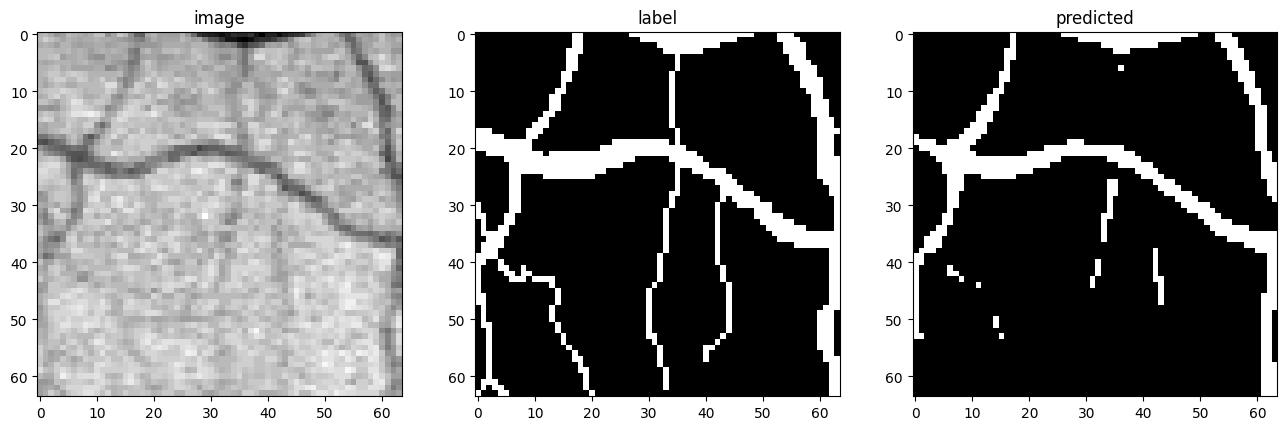

In [ ]:
sample_img = implementation_check['sample_img']
sample_label = implementation_check['sample_label']
sample_pred = implementation_check['sample_pred_hard']

visualize_side_by_3(sample_img, 'image', sample_label, 'label', sample_pred, 'predicted', (0,255),(0,1),(0,1))
print("Dice coefficient: {:.4f}".format(dice_coef(sample_label, sample_pred)))
print("Expected dice coefficient between sample label and sample predicted mask should be 0.7689")

### Task 9: Calculate the average dice

Now we have a function that calculates the dice coefficient between two binary segmentation masks. In this task, we will obtain the dice coefficient scores of every thresholded predictions on the validation dataset with their corresponding label masks, and average them all to a single value.

In [ ]:
def avg_dice(y_val, val_preds_thresh):
    """Calculates the average dice coefficient score across all thresholded predictions & label pair of the validation dataset.

    Parameters
    ----------
    y_val : np.ndarray
        Ground truth segmentation labels array of the validation dataset
    val_preds : np.ndarray
        Predicted segmentation masks array on the validation dataset

    Returns
    ----------
    float
        Average dice score coefficient.
    """

    dice_list = []
    for i in range(y_val.shape[0]):
      dice_list.append(dice_coef(y_val[i,...], val_preds_thresh[i,...]))
    average_dice = np.mean(dice_list)

    return average_dice


Now, let's test the average dice coefficient score of our model's performance on the validation dataset. If you implemented all the above steps correctly and strictly followed the sample suggestion of the model, you should expect an average validation dice coefficient score of around 0.65~0.7, which is reasonable, but not amazing. Improve your model by conducting various experiments on your autoencoder model based on what you have learned during class and you have explored!

<br>

On a side note, your model's performance on this validation dataset will roughly align with the performance when evaluated on the test dataset.

In [ ]:
print("{:.4f}".format(avg_dice(y_val, val_preds_thresh)))

0.7627


In [ ]:
# Produce vessel mask prediction on the test retinal images.
x_test_raw = retinal_vessel_data["x_test"][...,np.newaxis]
x_test_enhanced = contrast_stretch(x_test_raw)
x_test = rescale_01(x_test_enhanced)
test_preds = model.predict(x_test, batch_size=16)
test_preds_thresh = threshold(test_preds, 0.5)
np.save('submission.npy', test_preds_thresh)


11/11 [==============================] - 0s 30ms/step


In [ ]:
# Saving the model
model.save('trained_model_snapshot.h5')

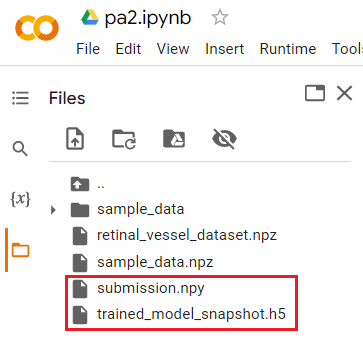